# POS Tagging with LSTM

In this notebook, I will use a LSTM to predict the POS tags of words in a sentence. In order to do so we will use the `MyTagger` class. This class will be responsible for training the model and predicting the POS tags of a sentence. 


In [1]:
from tagger import MyTagger

2024-10-29 11:58:46.047364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## English POS Tags

We will start with a firts model that will predict the POS tags of a sentence in English, using use the dataset from the [UD English EWT](https://github.com/UniversalDependencies/UD_English-EWT).

### Initial set up

#### Creating the tagger

The `MyTagger` class will be initialized with the three files that contain the training data, the validation data and the test data.

In [2]:
eng_tagger = MyTagger(
    train_filename = "data/english/en_ewt-ud-train.conllu",
    val_filename = "data/english/en_ewt-ud-dev.conllu",
    test_filename = "data/english/en_ewt-ud-test.conllu"
)

#### Max sentence length

We need to make some decisions regarding the model's parameters. For example, we should define the maximum sentence length in the dataset and the size of the vocabulary. Below, we present some statistics about the dataset. It is important to note that this analysis is based solely on the training dataset, as we should not use the validation or test sets for this purpose. Using information from those sets to inform model design could lead to biased results.

We should make a decission about the maximum length of the sentences. We observe that the average length of the sentences is aproximately 16 words and the standard deviation is 12.4. Also, we observe that there are not a lot of sentences with more than 100 words (only 0.04% of the sentences).

Max sentence length: 159
Mean sentence length: 16.31
Standard deviation of sentence length: 12.4


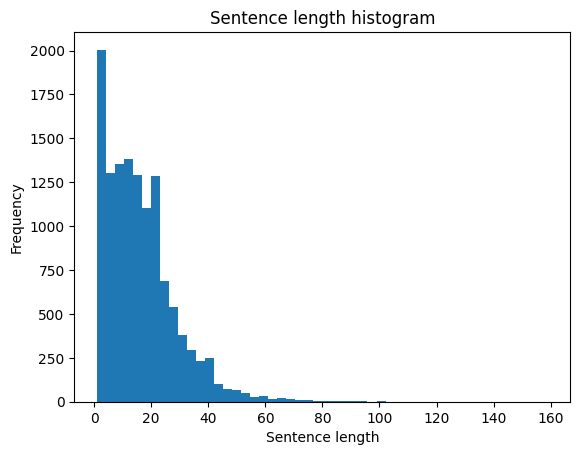

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the maximum length of the sentences
sentence_num_words = [len(sentence.split()) for sentence in eng_tagger.X_train]
max_len = max(sentence_num_words)
print(f"Max sentence length: {round(max_len, 2)}")

mean_len = np.mean(sentence_num_words)
std_len = np.std(sentence_num_words)
print(f"Mean sentence length: {round(mean_len, 2)}")
print(f"Standard deviation of sentence length: {round(std_len, 2)}")

# Build an histogram of the number of words in the sentences
plt.hist(sentence_num_words, bins=50)
plt.xlabel("Sentence length")
plt.ylabel("Frequency")
plt.title("Sentence length histogram")
plt.show()

In [4]:
max_sentence_num_words = 100
sentences_over_max_length = [i for i, num_words in enumerate(sentence_num_words) if num_words > max_sentence_num_words]
print(f"Number of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length)}")
print(
    f"Percentage of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length) / len(eng_tagger.X_train) * 100:.2f}%\n"
)

for i in sentences_over_max_length:
    print(
        f'Sentence {i} has more than {max_sentence_num_words} words ({sentence_num_words[i]}). Sentence: "{eng_tagger.X_train[i]}"'
)

Number of sentences over 100 words: 5
Percentage of sentences over 100 words: 0.04%

Sentence 6090 has more than 100 words (102). Sentence: "That is what is about to happen with Judge Samuel Alito , in my opinion , because he has one tragic flaw - a very serious blind spot in his thinking - which makes him completely unacceptable for the position of Supreme Court Justice : He does not really agree with the system of " Checks and Balances " built into the Constitution , and he is ready to start tearing it down in order to follow the " Unitary Executive Theory , " which calls for vastly - increased Presidential Power at the expense of Congress and the Supreme Court ."
Sentence 6470 has more than 100 words (104). Sentence: "" I do not feel it has changed the US citizens which is what was needed , even now the majority want " Gas " despite the fact they are polluting the world more than any other country in the world and refuse to stop , perhaps this natural disaster , which let 's face it

As there are only few sentences with more than 100 words, we decide to set the maximum length of the sentences to 100. We will pad the sentences with zeros if they are shorter than 100 words and we will truncate them if they are longer than 100 words. To truncate them we have to options:

- Truncate the sentences from the end of the sentence.
- Locate the last punctuation mark before the token 100 and truncate the sentence from there.


In [5]:
from utils import locate_last_punctuation_mark

for i in sentences_over_max_length:
    print(f"Last punctuation mark in sentence {i}: {locate_last_punctuation_mark(eng_tagger.y_train[i], limit=100)}")

Last punctuation mark in sentence 6090: 88
Last punctuation mark in sentence 6470: 93
Last punctuation mark in sentence 6724: 84
Last punctuation mark in sentence 6779: 92
Last punctuation mark in sentence 7506: -1


As not all the sentences that overlap the 100 words limit have a punctuation mark at the 100th token, we decide to truncate the sentences from the last punctuation mark before the 100th token, in case there is one. If there is no punctuation mark before the 100th token, we truncate the sentence from the 100th token.

We must do this for the training, validation and test sets. This can be done by calling the `preprocess_data` method of the `MyTagger` class. By specifying `with_punctuation=True` and `max_sentence_num_words = 100` as arguments, the method will truncate the sentences from the last punctuation mark before the 100th token. If there is no punctuation mark before the 100th token, the sentence will be truncated from the 100th token. 

The preprocessing includes truncating the sentences and padding them with zeros after the truncation. The same will be done for the labels.


In [6]:
eng_tagger.preprocess_data(max_sentence_num_words=100, with_punctuation=True)

In [10]:
print(f"Sentence 1: {eng_tagger.X_train[0]}")
print(f"Label 1: {eng_tagger.y_train[0]}")

Sentence 1: Al - Zaman : American forces killed Shaikh Abdullah al - Ani , the preacher at the mosque in the town of Qaim , near the Syrian border .
Label 1: [12 13 12 13  1  8 16 12 12 12 13 12 13  6  8  2  6  8  2  6  8  2 12 13
  2  6  1  8 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


### Building the model


We calculated the number of unique words in the training and test sets, which are 19,674 and 5,629, respectively. Notably, many words present in the training set do not appear in the test set. This suggests that it may not be necessary to include all the words from the training set in the vocabulary, as this likely won't impact the model's performance. To determine the optimal vocabulary size, we also analyzed the frequency distribution of words in the training set. We found that only 9,868 words appear more than once in the training set, while the remaining 9,806 words appear only once. This suggests that we could set the vocabulary size to 10,000 without losing much information.


In [7]:
X_plain_train = {token for sentence in eng_tagger.X_train for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_train)}")

X_plain_test = {token for sentence in eng_tagger.X_test for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_test)}")

Number of unique tokens: 19671
Number of unique tokens: 5629


In [8]:
from utils import calculate_word_frequency

frequencies = calculate_word_frequency(eng_tagger.X_train)
# We count the number of words with more than 1, 2 and 3 occurrences
num_words_gt_1 = sum(1 for word, freq in frequencies.items() if freq > 1)
num_words_gt_2 = sum(1 for word, freq in frequencies.items() if freq > 2)
num_words_gt_3 = sum(1 for word, freq in frequencies.items() if freq > 3)

print(f"Number of words with more than 1 occurrence: {num_words_gt_1}")
print(f"Number of words with more than 2 occurrences: {num_words_gt_2}")
print(f"Number of words with more than 3 occurrences: {num_words_gt_3}")

Number of words with more than 1 occurrence: 9868
Number of words with more than 2 occurrences: 6727
Number of words with more than 3 occurrences: 5142


We start by building a simple model with the following architecture:
- `Vocabulary size`: 10,000
- `Embedding size`: 50
- `LSTM units`: 64
- `Bidirectional`: False  

In [9]:
tagger.build_model(
    vocabulary_size = 10000, 
    units = 64, 
    output_dim = 50, 
    bidirectional = False
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 lstm (LSTM)                 (None, 100, 64)           29440     
                                                                 
 time_distributed (TimeDist  (None, 100, 18)           1170      
 ributed)                                                        
                                                                 
Total params: 530610 (2.02 MB)
Trainable params: 530610 (2.02

And we perform a first training with the following hyperparameters:
- `Batch size`: 64
- `Epochs`: 10
- `Optimizer`: Adam

In [10]:
tagger.train(
    epochs = 10, 
    batch_size = 64, 
    optimizer = "adam",
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)

Epoch 1/10
196/196 [==============================] - 30s 123ms/step - loss: 1.9695 - accuracy: 0.4526 - val_loss: 0.9119 - val_accuracy: 0.7677
Epoch 2/10
196/196 [==============================] - 23s 118ms/step - loss: 0.5294 - accuracy: 0.8661 - val_loss: 0.4554 - val_accuracy: 0.8745
Epoch 3/10
196/196 [==============================] - 22s 111ms/step - loss: 0.2986 - accuracy: 0.9154 - val_loss: 0.3844 - val_accuracy: 0.8862
Epoch 4/10
196/196 [==============================] - 22s 111ms/step - loss: 0.2359 - accuracy: 0.9275 - val_loss: 0.3675 - val_accuracy: 0.8879
Epoch 5/10
196/196 [==============================] - 22s 110ms/step - loss: 0.2052 - accuracy: 0.9344 - val_loss: 0.3496 - val_accuracy: 0.8928
Epoch 6/10
196/196 [==============================] - 22s 110ms/step - loss: 0.1851 - accuracy: 0.9391 - val_loss: 0.3516 - val_accuracy: 0.8925
Epoch 7/10
196/196 [==============================] - 22s 111ms/step - loss: 0.1696 - accuracy: 0.9437 - val_loss: 0.3538 - val_ac

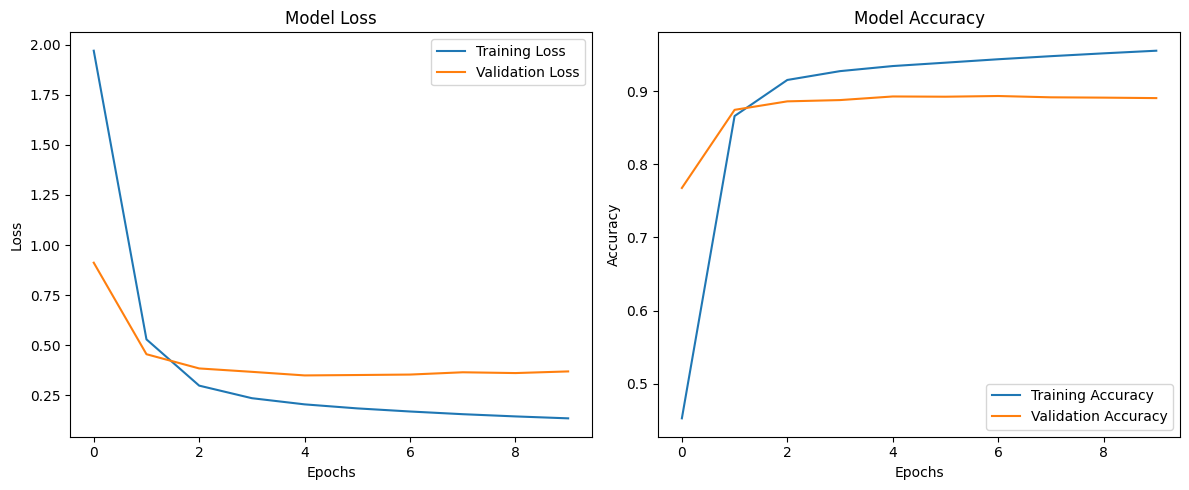

In [13]:
tagger.plot_training_history()

In [15]:
tagger.evaluate()
tagger.predict("I am a sentence .")

1/1 [==============================] - 0s 158ms/step
Prediction: ['PRON', 'AUX', 'DET', 'NOUN', 'PUNCT']


In [16]:
tagger.save_model(model_filename = "initial_model")

Model saved in ./models/initial_model.keras
Training history saved in ./models/initial_model_training_history.json


It seems that we may have some overfitting in our model.